In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load cleaned data from EDA
df = pd.read_csv('../data/AIML Dataset.csv')
print(f"Dataset loaded: {df.shape}")
print(f"Fraud cases: {df['isFlaggedFraud'].sum()}")

Dataset loaded: (6362620, 11)
Fraud cases: 16


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
# Feature 1: Balance changes for origin account
df['balanceChangeOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']

# Feature 2: Balance changes for destination account
df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Feature 3: Check if transaction amount matches balance change
df['amountMatchesChange'] = (df['amount'] == df['balanceChangeOrig']).astype(int)

# Feature 4: Ratio of amount to original balance
df['amountToOldBalanceRatio'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # +1 to avoid division by zero

# Feature 5: Is origin account emptied?
df['originEmptied'] = (df['newbalanceOrig'] == 0).astype(int)

# Feature 6: Is destination account new?
df['destIsNew'] = (df['oldbalanceDest'] == 0).astype(int)


print("\nNew features:")
new_features = ['balanceChangeOrig', 'balanceChangeDest', 'amountMatchesChange', 
                'amountToOldBalanceRatio', 'originEmptied', 'destIsNew']
df[new_features].head(10)


New features:


,balanceChangeOrig,balanceChangeDest,amountMatchesChange,amountToOldBalanceRatio,originEmptied,destIsNew
0,9839.64,0.00,0,0.057834,0,1
1,1864.28,0.00,0,0.087731,0,1
2,181.00,0.00,1,0.994505,1,1
3,181.00,-21182.00,1,0.994505,1,0
4,11668.14,0.00,1,0.280788,0,1
5,7817.71,0.00,0,0.145146,0,1
6,7107.77,0.00,0,0.038799,0,1
7,7861.64,0.00,0,0.044646,0,1
8,2671.00,0.00,0,1.506123,1,1
9,5337.77,-1549.21,0,0.127940,0,0


In [6]:
# Feature 7: Transaction type encoding
le_type = LabelEncoder()
df['type_encoded'] = le_type.fit_transform(df['type'])

print("Transaction type mapping:")
for i, trans_type in enumerate(le_type.classes_):
    print(f"  {trans_type}: {i}")

# Feature 8: Is it a high-risk transaction type? (TRANSFER or CASH_OUT)
df['isHighRiskType'] = df['type'].isin(['TRANSFER', 'CASH_OUT']).astype(int)

# Feature 9: Transaction amount bins (categorize amounts)
df['amountBin'] = pd.cut(df['amount'], 
                         bins=[0, 1000, 10000, 100000, 1000000, float('inf')],
                         labels=['very_low', 'low', 'medium', 'high', 'very_high'])

# Feature 10: Time-based features (from step column)
df['hour'] = (df['step'] % 24)  # Assuming step represents hours
df['day'] = (df['step'] // 24)   # Day number

df[['type', 'type_encoded', 'isHighRiskType', 'amountBin', 'hour', 'day']].head(10)

Transaction type mapping:
  CASH_IN: 0
  CASH_OUT: 1
  DEBIT: 2
  PAYMENT: 3
  TRANSFER: 4


,type,type_encoded,isHighRiskType,amountBin,hour,day
0,PAYMENT,3,0,low,1,0
1,PAYMENT,3,0,low,1,0
2,TRANSFER,4,1,very_low,1,0
3,CASH_OUT,1,1,very_low,1,0
4,PAYMENT,3,0,medium,1,0
5,PAYMENT,3,0,low,1,0
6,PAYMENT,3,0,low,1,0
7,PAYMENT,3,0,low,1,0
8,PAYMENT,3,0,low,1,0
9,DEBIT,2,0,low,1,0


Correlation with Fraud (isFlaggedFraud):
isFlaggedFraud             1.000000
day                        0.003296
type_encoded               0.002685
destIsNew                  0.001844
isHighRiskType             0.001806
balanceChangeOrig          0.000230
amountToOldBalanceRatio   -0.000220
balanceChangeDest         -0.000242
amountMatchesChange       -0.000432
hour                      -0.000462
originEmptied             -0.001816
Name: isFlaggedFraud, dtype: float64


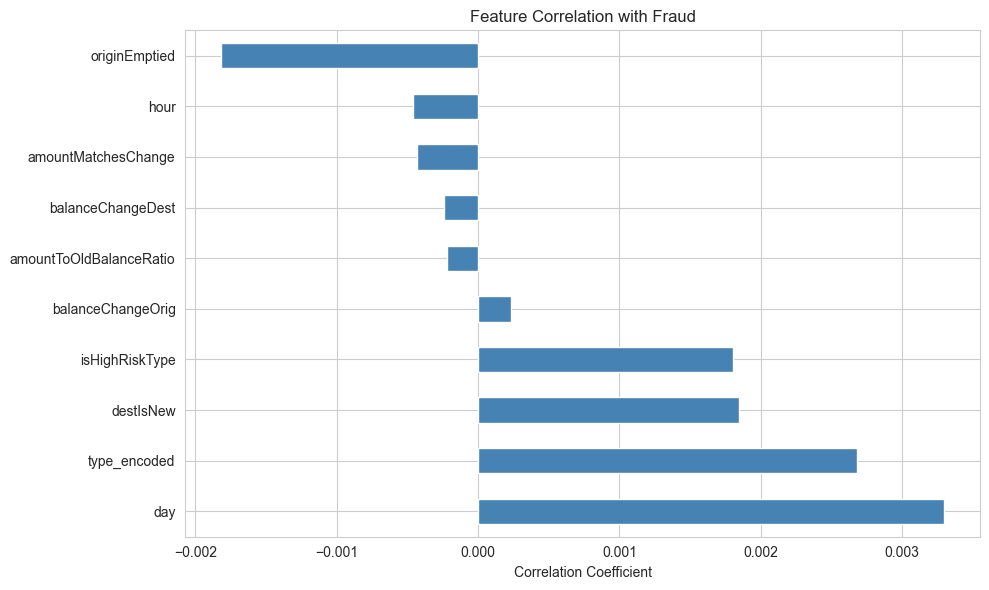

In [7]:
# Check correlation with fraud
features_to_check = ['balanceChangeOrig', 'balanceChangeDest', 'amountMatchesChange',
                     'amountToOldBalanceRatio', 'originEmptied', 'destIsNew',
                     'type_encoded', 'isHighRiskType', 'hour', 'day']

print("Correlation with Fraud (isFlaggedFraud):")
print("=" * 50)
correlations = df[features_to_check + ['isFlaggedFraud']].corr()['isFlaggedFraud'].sort_values(ascending=False)
print(correlations)

# Visualize top correlations
plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Fraud')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

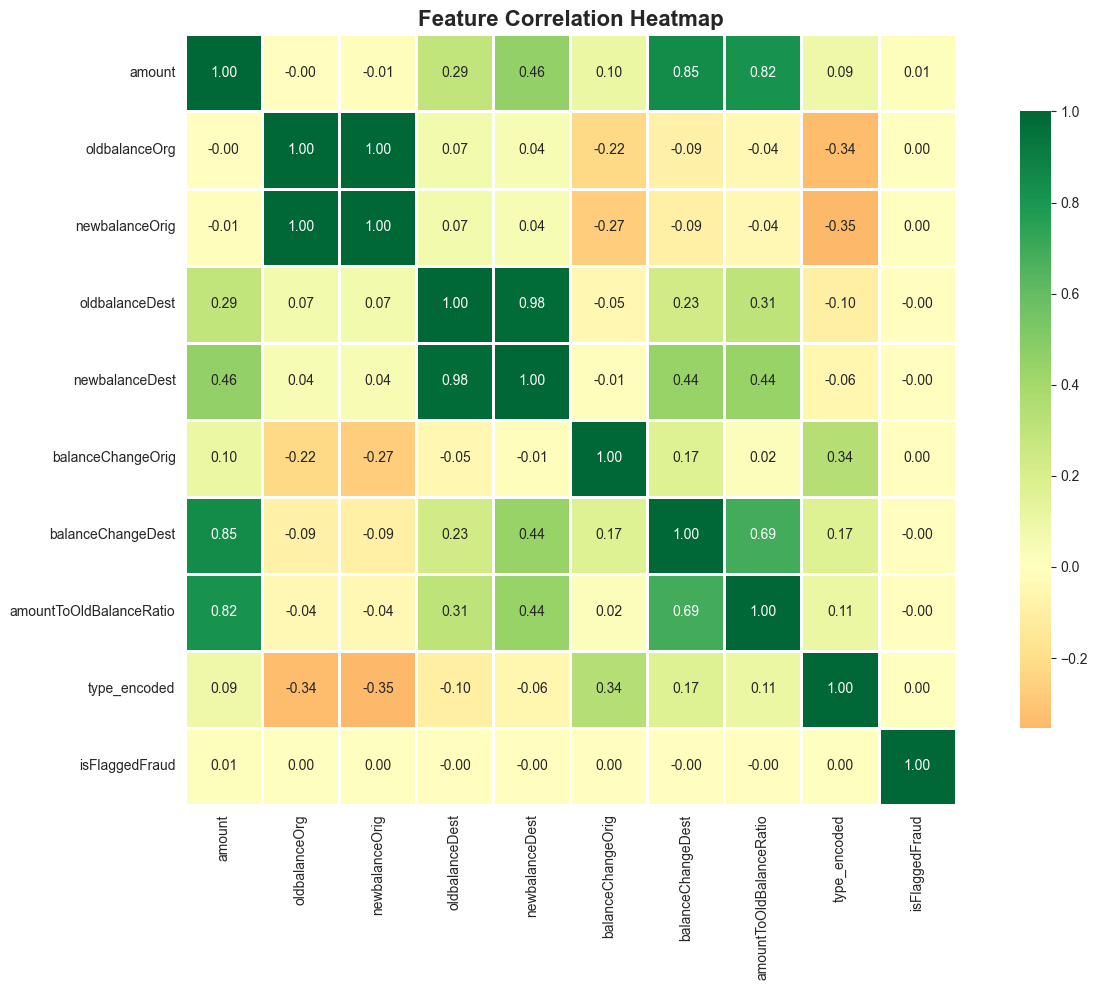


Highly Correlated Feature Pairs (|correlation| > 0.8):
amount <-> balanceChangeDest: 0.846
amount <-> amountToOldBalanceRatio: 0.817
oldbalanceOrg <-> newbalanceOrig: 0.999
oldbalanceDest <-> newbalanceDest: 0.977


In [8]:
# Select numeric features for correlation analysis
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
                    'newbalanceDest', 'balanceChangeOrig', 'balanceChangeDest',
                    'amountToOldBalanceRatio', 'type_encoded', 'isFlaggedFraud']

# Create correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated features (potential multicollinearity)
print("\nHighly Correlated Feature Pairs (|correlation| > 0.8):")
print("=" * 60)
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            print(f"{correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

In [9]:
# Identify highly correlated features (potential multicollinearity)
print("Highly Correlated Feature Pairs (|correlation| > 0.8):")
print("=" * 70)

correlation_matrix = df[numeric_features].corr()
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feature1, feature2, corr_value))
            print(f"{feature1:25s} <-> {feature2:25s}: {corr_value:6.3f}")

if len(high_corr_pairs) == 0:
    print("No highly correlated pairs found (|correlation| > 0.8)")
else:
    print(f"\nTotal highly correlated pairs: {len(high_corr_pairs)}")

Highly Correlated Feature Pairs (|correlation| > 0.8):
amount                    <-> balanceChangeDest        :  0.846
amount                    <-> amountToOldBalanceRatio  :  0.817
oldbalanceOrg             <-> newbalanceOrig           :  0.999
oldbalanceDest            <-> newbalanceDest           :  0.977

Total highly correlated pairs: 4


In [10]:
# Define final features for modeling
final_features = [
    # Original features
    'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    
    # Engineered features
    'balanceChangeOrig', 'balanceChangeDest', 'amountMatchesChange',
    'amountToOldBalanceRatio', 'originEmptied', 'destIsNew',
    'isHighRiskType', 'hour', 'day'
]

# Create feature matrix
X = df[final_features].copy()
y = df['isFlaggedFraud'].copy()

print(f"Features: {len(final_features)}")
print(f"Samples: {len(X)}")
print(f"\nFeature list:")
for i, feat in enumerate(final_features, 1):
    print(f"  {i}. {feat}")

Features: 15
Samples: 6362620

Feature list:
  1. type_encoded
  2. amount
  3. oldbalanceOrg
  4. newbalanceOrig
  5. oldbalanceDest
  6. newbalanceDest
  7. balanceChangeOrig
  8. balanceChangeDest
  9. amountMatchesChange
  10. amountToOldBalanceRatio
  11. originEmptied
  12. destIsNew
  13. isHighRiskType
  14. hour
  15. day


In [11]:
# Check for missing values
print("Missing Values:")
print(X.isnull().sum())

# Check for infinite values
print("\nInfinite Values:")
print(np.isinf(X).sum())

# Replace infinities with NaN, then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())



Missing Values:
type_encoded               0
amount                     0
oldbalanceOrg              0
newbalanceOrig             0
oldbalanceDest             0
newbalanceDest             0
balanceChangeOrig          0
balanceChangeDest          0
amountMatchesChange        0
amountToOldBalanceRatio    0
originEmptied              0
destIsNew                  0
isHighRiskType             0
hour                       0
day                        0
dtype: int64

Infinite Values:
type_encoded               0
amount                     0
oldbalanceOrg              0
newbalanceOrig             0
oldbalanceDest             0
newbalanceDest             0
balanceChangeOrig          0
balanceChangeDest          0
amountMatchesChange        0
amountToOldBalanceRatio    0
originEmptied              0
destIsNew                  0
isHighRiskType             0
hour                       0
day                        0
dtype: int64


In [12]:
# Split data: 80% train, 20% test
# Use stratify to maintain fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split Summary:")
print("=" * 50)
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"  - Fraud: {y_train.sum():,} ({y_train.mean()*100:.4f}%)")
print(f"  - Legitimate: {(~y_train.astype(bool)).sum():,}")

print(f"\nTest set: {X_test.shape[0]:,} samples")
print(f"  - Fraud: {y_test.sum():,} ({y_test.mean()*100:.4f}%)")
print(f"  - Legitimate: {(~y_test.astype(bool)).sum():,}")

Data Split Summary:
Training set: 5,090,096 samples
  - Fraud: 13 (0.0003%)
  - Legitimate: 5,090,083

Test set: 1,272,524 samples
  - Fraud: 3 (0.0002%)
  - Legitimate: 1,272,521


In [13]:
# Standardize features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=final_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=final_features)

print("\nScaled feature sample:")
X_train_scaled.head()


Scaled feature sample:


,type_encoded,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceChangeOrig,balanceChangeDest,amountMatchesChange,amountToOldBalanceRatio,originEmptied,destIsNew,isHighRiskType,hour,day
0,-0.528837,0.079279,-0.288552,-0.292333,0.125323,0.144089,0.145938,0.127935,-0.272802,-0.136234,0.873437,-0.859774,1.138613,-1.231311,0.084190
1,1.693163,0.406883,-0.240477,-0.292333,-0.258372,-0.157765,1.094184,0.371361,-0.272802,-0.140019,0.873437,-0.859774,1.138613,-0.074402,-0.253577
2,-0.528837,-0.189151,-0.288592,-0.292333,-0.295707,-0.289465,0.145132,-0.071521,-0.272802,-0.008398,0.873437,-0.859774,1.138613,1.082507,0.759723
3,0.952496,-0.270878,-0.288592,-0.292333,-0.323208,-0.332946,0.145132,-0.153679,-0.272802,-0.105691,0.873437,1.163096,-0.878262,1.082507,0.253073
4,-1.269504,-0.068965,3.331636,3.330936,0.021703,-0.051217,-0.799245,-0.325141,-0.272802,-0.140025,-1.144902,-0.859774,-0.878262,0.851125,0.590840


In [14]:
# Save processed datasets
import os

# Create processed data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save unscaled versions
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Save scaled versions
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)

# Save the scaler for future use
import joblib
joblib.dump(scaler, '../data/processed/scaler.pkl')

print("\nSaved files:")
print("  - X_train.csv, X_test.csv")
print("  - y_train.csv, y_test.csv")
print("  - X_train_scaled.csv, X_test_scaled.csv")
print("  - scaler.pkl")


Saved files:
  - X_train.csv, X_test.csv
  - y_train.csv, y_test.csv
  - X_train_scaled.csv, X_test_scaled.csv
  - scaler.pkl


In [15]:
# Define TWO feature sets

# 1. FULL feature set (for tree-based models like Random Forest, XGBoost)
full_features = [
    # Original features
    'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    
    # Engineered features
    'balanceChangeOrig', 'balanceChangeDest', 'amountMatchesChange',
    'amountToOldBalanceRatio', 'originEmptied', 'destIsNew',
    'isHighRiskType', 'hour', 'day'
]

# 2. REDUCED feature set (remove highly correlated ones for linear models)
reduced_features = [
    'type_encoded', 'amount', 'oldbalanceOrg',  # Removed newbalanceOrig (corr 0.999)
    'oldbalanceDest',  # Removed newbalanceDest (corr 0.977)
    'balanceChangeOrig', 'amountMatchesChange',  # Removed balanceChangeDest and amountToOldBalanceRatio
    'originEmptied', 'destIsNew', 'isHighRiskType', 'hour', 'day'
]


final_features = full_features

# Create feature matrix
X = df[final_features].copy()
y = df['isFlaggedFraud'].copy()


print(f"Full features: {len(full_features)}")
print(f"Reduced features: {len(reduced_features)}")
print(f"Using: Full feature set ({len(final_features)} features)")
print(f"Samples: {len(X):,}")
print(f"\nFeature list:")
for i, feat in enumerate(final_features, 1):
    print(f"  {i:2d}. {feat}")

Full features: 15
Reduced features: 11
Using: Full feature set (15 features)
Samples: 6,362,620

Feature list:
   1. type_encoded
   2. amount
   3. oldbalanceOrg
   4. newbalanceOrig
   5. oldbalanceDest
   6. newbalanceDest
   7. balanceChangeOrig
   8. balanceChangeDest
   9. amountMatchesChange
  10. amountToOldBalanceRatio
  11. originEmptied
  12. destIsNew
  13. isHighRiskType
  14. hour
  15. day


In [16]:
# Check for missing values
print("Missing Values:")
print(X.isnull().sum())

# Check for infinite values
print("\nInfinite Values:")
print(np.isinf(X).sum())

# Replace infinities with NaN, then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())


Missing Values:
type_encoded               0
amount                     0
oldbalanceOrg              0
newbalanceOrig             0
oldbalanceDest             0
newbalanceDest             0
balanceChangeOrig          0
balanceChangeDest          0
amountMatchesChange        0
amountToOldBalanceRatio    0
originEmptied              0
destIsNew                  0
isHighRiskType             0
hour                       0
day                        0
dtype: int64

Infinite Values:
type_encoded               0
amount                     0
oldbalanceOrg              0
newbalanceOrig             0
oldbalanceDest             0
newbalanceDest             0
balanceChangeOrig          0
balanceChangeDest          0
amountMatchesChange        0
amountToOldBalanceRatio    0
originEmptied              0
destIsNew                  0
isHighRiskType             0
hour                       0
day                        0
dtype: int64


In [17]:
# Split data: 80% train, 20% test
# Use stratify to maintain fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split Summary:")
print("=" * 50)
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"  - Fraud: {y_train.sum():,} ({y_train.mean()*100:.4f}%)")
print(f"  - Legitimate: {(~y_train.astype(bool)).sum():,}")

print(f"\nTest set: {X_test.shape[0]:,} samples")
print(f"  - Fraud: {y_test.sum():,} ({y_test.mean()*100:.4f}%)")
print(f"  - Legitimate: {(~y_test.astype(bool)).sum():,}")

Data Split Summary:
Training set: 5,090,096 samples
  - Fraud: 13 (0.0003%)
  - Legitimate: 5,090,083

Test set: 1,272,524 samples
  - Fraud: 3 (0.0002%)
  - Legitimate: 1,272,521


In [18]:
# Standardize features (important for some models)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=final_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=final_features, index=X_test.index)

print("\nScaled feature sample (first 5 rows):")
X_train_scaled.head()


Scaled feature sample (first 5 rows):


,type_encoded,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,balanceChangeOrig,balanceChangeDest,amountMatchesChange,amountToOldBalanceRatio,originEmptied,destIsNew,isHighRiskType,hour,day
3224891,-0.528837,0.079279,-0.288552,-0.292333,0.125323,0.144089,0.145938,0.127935,-0.272802,-0.136234,0.873437,-0.859774,1.138613,-1.231311,0.084190
2591475,1.693163,0.406883,-0.240477,-0.292333,-0.258372,-0.157765,1.094184,0.371361,-0.272802,-0.140019,0.873437,-0.859774,1.138613,-0.074402,-0.253577
5117333,-0.528837,-0.189151,-0.288592,-0.292333,-0.295707,-0.289465,0.145132,-0.071521,-0.272802,-0.008398,0.873437,-0.859774,1.138613,1.082507,0.759723
3916982,0.952496,-0.270878,-0.288592,-0.292333,-0.323208,-0.332946,0.145132,-0.153679,-0.272802,-0.105691,0.873437,1.163096,-0.878262,1.082507,0.253073
4679039,-1.269504,-0.068965,3.331636,3.330936,0.021703,-0.051217,-0.799245,-0.325141,-0.272802,-0.140025,-1.144902,-0.859774,-0.878262,0.851125,0.590840


In [19]:
# Save processed datasets
import os
import joblib

# Create processed data directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save unscaled versions
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False, header=True)
y_test.to_csv('../data/processed/y_test.csv', index=False, header=True)

# Save scaled versions
X_train_scaled.to_csv('../data/processed/X_train_scaled.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test_scaled.csv', index=False)

# Save the scaler for future use
joblib.dump(scaler, '../data/processed/scaler.pkl')

print("\nSaved files in '../data/processed/':")
print("  - X_train.csv")
print("  - X_test.csv")
print("  - y_train.csv")
print("  - y_test.csv")
print("  - X_train_scaled.csv")
print("  - X_test_scaled.csv")
print("  - scaler.pkl")


Saved files in '../data/processed/':
  - X_train.csv
  - X_test.csv
  - y_train.csv
  - y_test.csv
  - X_train_scaled.csv
  - X_test_scaled.csv
  - scaler.pkl


In [20]:
# Feature engineering summary
print("=" * 70)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 70)
print(f"Total Features Created: {len(final_features)}")
print(f"Original Features: 6")
print(f"Engineered Features: {len(final_features) - 6}")
print(f"\nDataset Split:")
print(f"  Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Testing: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nClass Distribution:")
print(f"  Fraud cases in train: {y_train.sum()}")
print(f"  Fraud cases in test: {y_test.sum()}")
print(f"\nFraud Percentage:")
print(f"  Train: {y_train.mean()*100:.4f}%")
print(f"  Test: {y_test.mean()*100:.4f}%")


FEATURE ENGINEERING SUMMARY
Total Features Created: 15
Original Features: 6
Engineered Features: 9

Dataset Split:
  Training: 5,090,096 samples (80.0%)
  Testing: 1,272,524 samples (20.0%)

Class Distribution:
  Fraud cases in train: 13
  Fraud cases in test: 3

Fraud Percentage:
  Train: 0.0003%
  Test: 0.0002%
